In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [36]:
print(tf.__version__)

2.3.0


In [37]:
def get_files(base_dir, target_dir):
    count = 0
    path = get_path(base_dir, target_dir)
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            count+=len(glob.glob(os.path.join(dirname, filename)))
        return path, count

def get_path(base_dir, target_dir):
    path = os.path.join(base_dir,target_dir)
    return path

In [38]:
base_dir = 'archive (3)/chest_xray'
train_normal_dir = 'train/NORMAL'
train_pneumonia_dir = 'train/PNEUMONIA'
val_normal_dir = 'val/NORMAL'
val_pneumonia_dir = 'val/PNEUMONIA'
test_normal_dir = 'test/NORMAL'
test_pneumonia_dir = 'test/PNEUMONIA'

train_normal_path, train_normal_count = get_files(base_dir,train_normal_dir)
train_pneumonia_path, train_pneumonia_count = get_files(base_dir,train_pneumonia_dir)

val_normal_path, val_normal_count = get_files(base_dir,val_normal_dir)
val_pneumonia_path, val_pneumonia_count = get_files(base_dir,val_pneumonia_dir)

test_normal_path, test_normal_count = get_files(base_dir,test_normal_dir)
test_pneumonia_path, test_pneumonia_count = get_files(base_dir,test_pneumonia_dir)

print("No of Train Images: {}".format(train_normal_count + train_pneumonia_count))
print(" \u2022 No of Normal Images {}".format(train_normal_count))
print(" \u2022 No of Pneumonia Images {}".format(train_pneumonia_count))


No of Train Images: 5216
 • No of Normal Images 1341
 • No of Pneumonia Images 3875


In [39]:
train_data = []
for filename in os.listdir(train_normal_path):
    train_data.append((os.path.join(train_normal_path,filename),0))

for filename in os.listdir(train_pneumonia_path):
    train_data.append((os.path.join(train_pneumonia_path,filename),1))

train_data = pd.DataFrame(train_data, columns=['image_path', 'label'], index=None)
train_data = train_data.sample(frac=1).reset_index(drop=True)
        
val_data = []
for filename in os.listdir(val_normal_path):
    val_data.append((os.path.join(val_normal_path,filename),0))

for filename in os.listdir(val_pneumonia_path):
    val_data.append((os.path.join(val_pneumonia_path,filename),1))
        
val_data = pd.DataFrame(val_data, columns=['image_path', 'label'], index=None)
        
test_data = []
for filename in os.listdir(test_normal_path):
    test_data.append((os.path.join(test_normal_path,filename),0))

for filename in os.listdir(test_pneumonia_path):
    test_data.append((os.path.join(test_pneumonia_path,filename),1))

test_data = pd.DataFrame(test_data, columns=['image_path', 'label'], index=None)

print("Train Data {}".format(train_data.shape))
print("Validation Data {}".format(val_data.shape))
print("Test Data {}".format(test_data.shape))

Train Data (5216, 2)
Validation Data (16, 2)
Test Data (624, 2)


<AxesSubplot:>

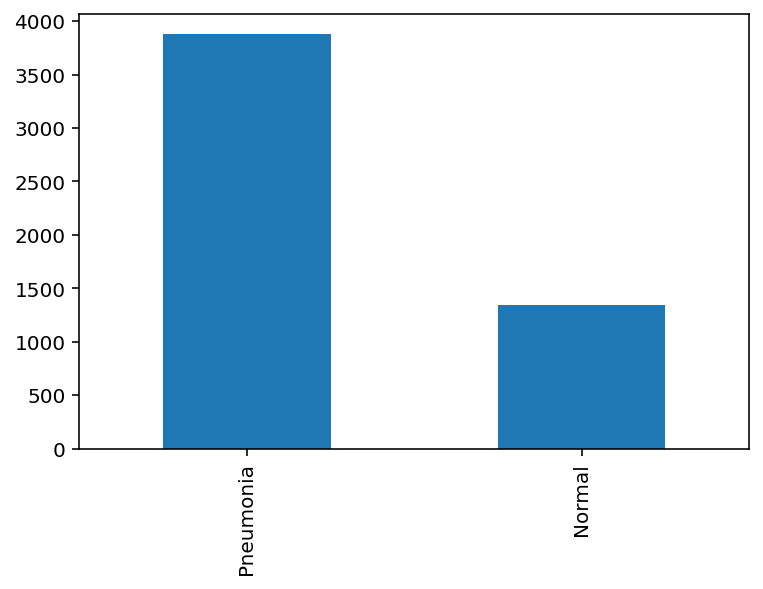

In [40]:
class_dict = {0:'Normal', 1:'Pneumonia'}
train_data['class_name'] = train_data.label.map(class_dict)
train_data['class_name'].value_counts().plot(kind='bar')

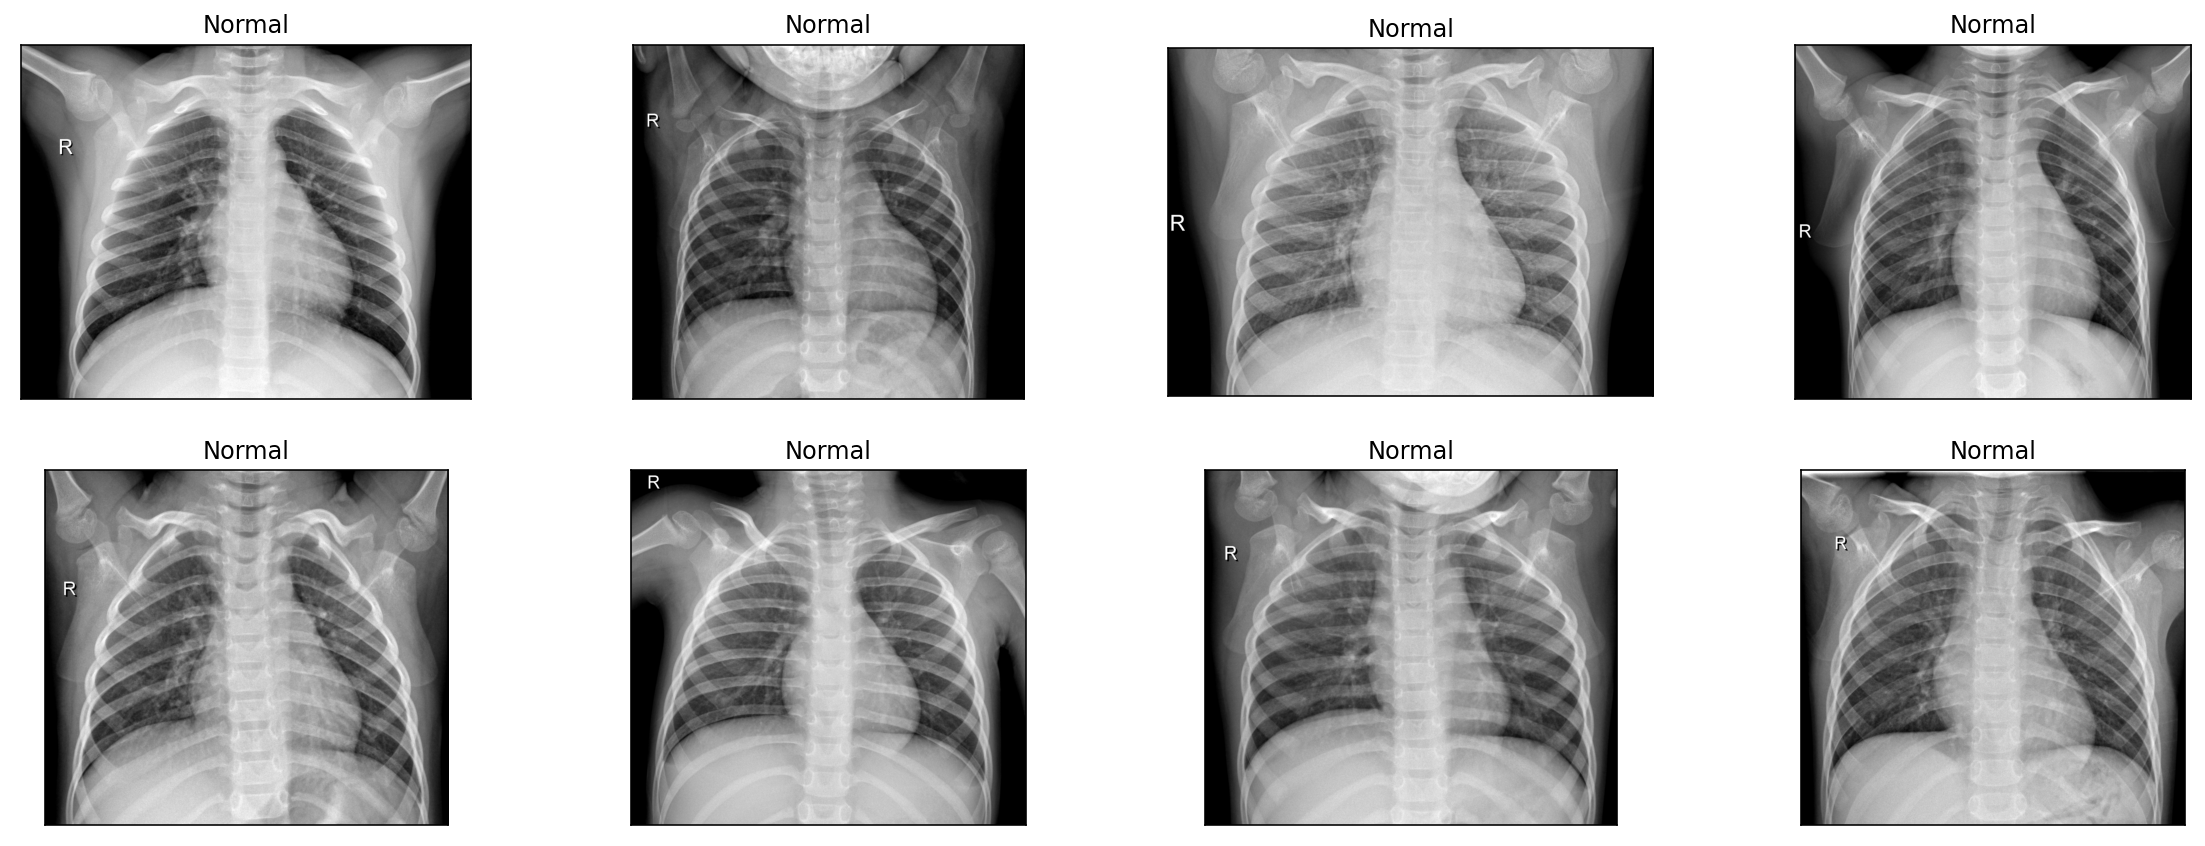

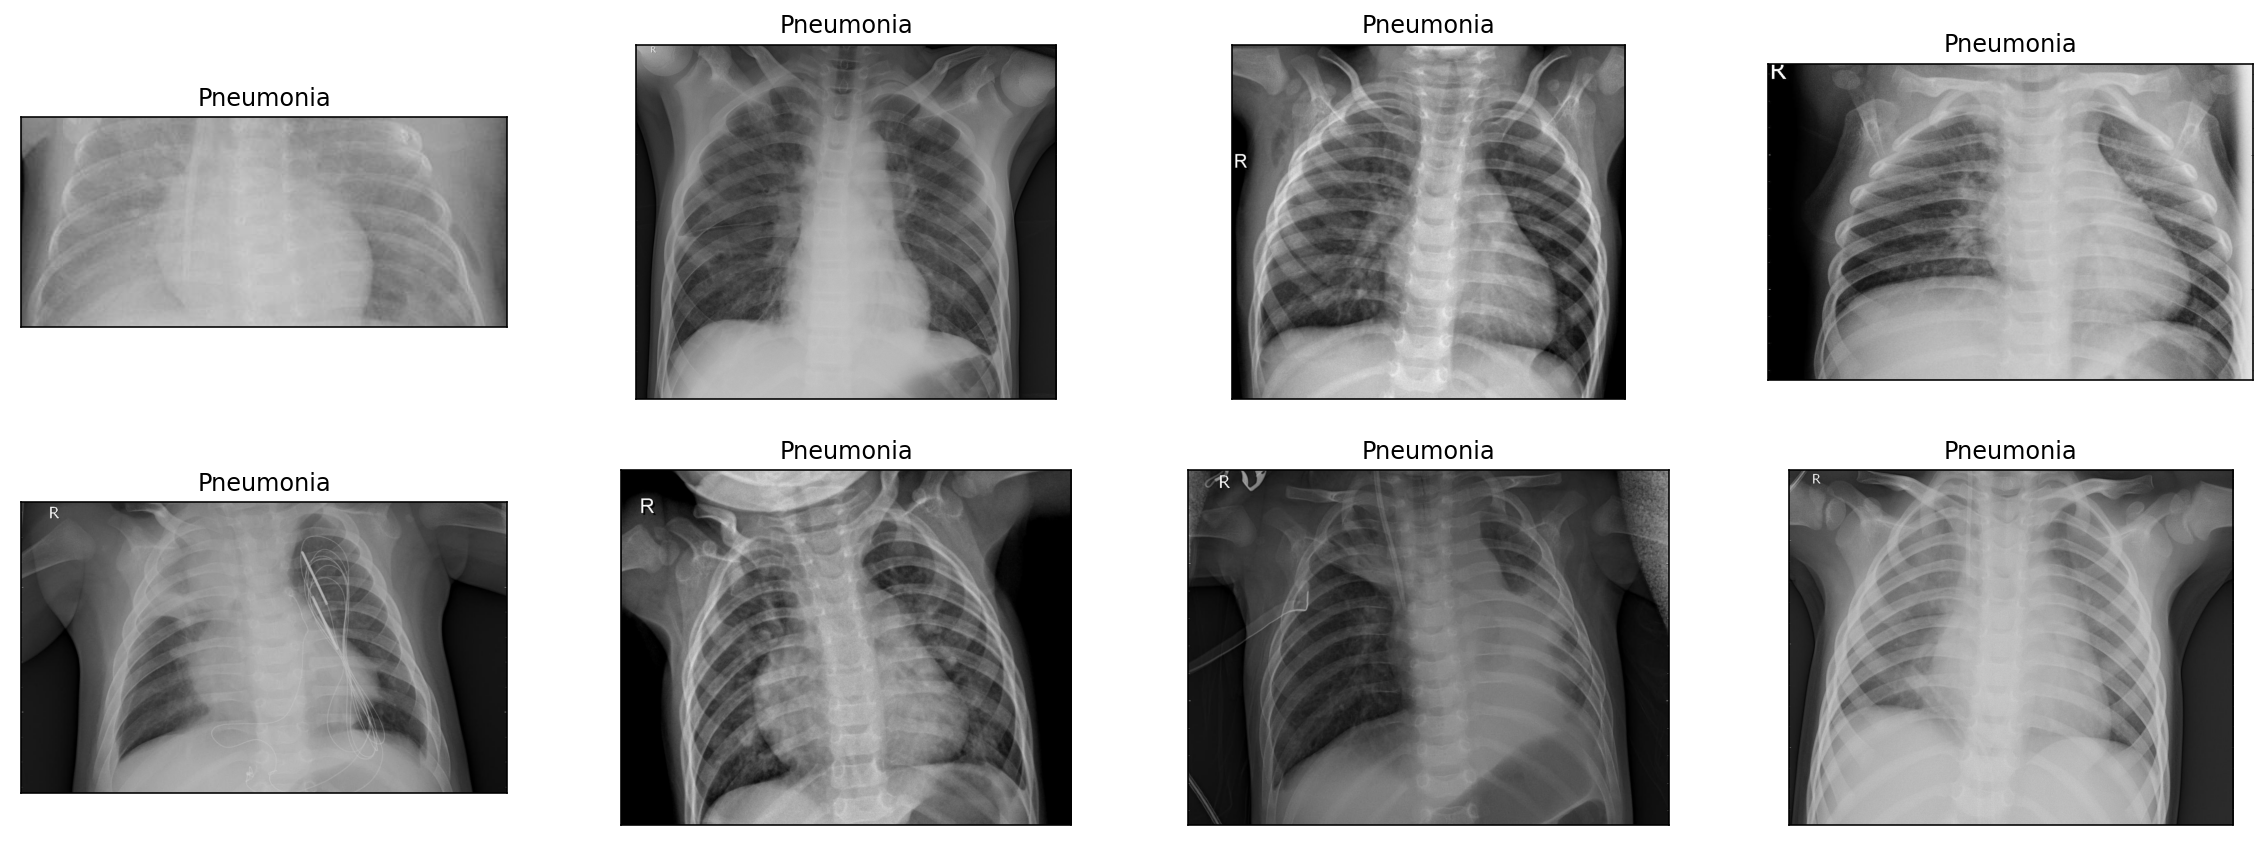

In [41]:
def visualize_img(images):
    fig = plt.figure(figsize=(20, 15))
    for i,path in enumerate(images):
        fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
        img = cv2.imread(path)
        plt.imshow(img)
        plt.title(train_data[train_data.image_path == path].class_name.values[0])
        
for i in range(2):
    images = train_data[train_data.label == i].image_path
    images = np.random.choice(images , 8)
    visualize_img(images)

In [42]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [43]:
BATCH_SIZE = 32
IMG_SHAPE  = 224

train_image_gen = ImageDataGenerator(rescale=1./255,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     brightness_range=[0.2,1.0],
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col='class_name',
                                              class_mode='binary',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))

Found 5216 validated image filenames belonging to 2 classes.


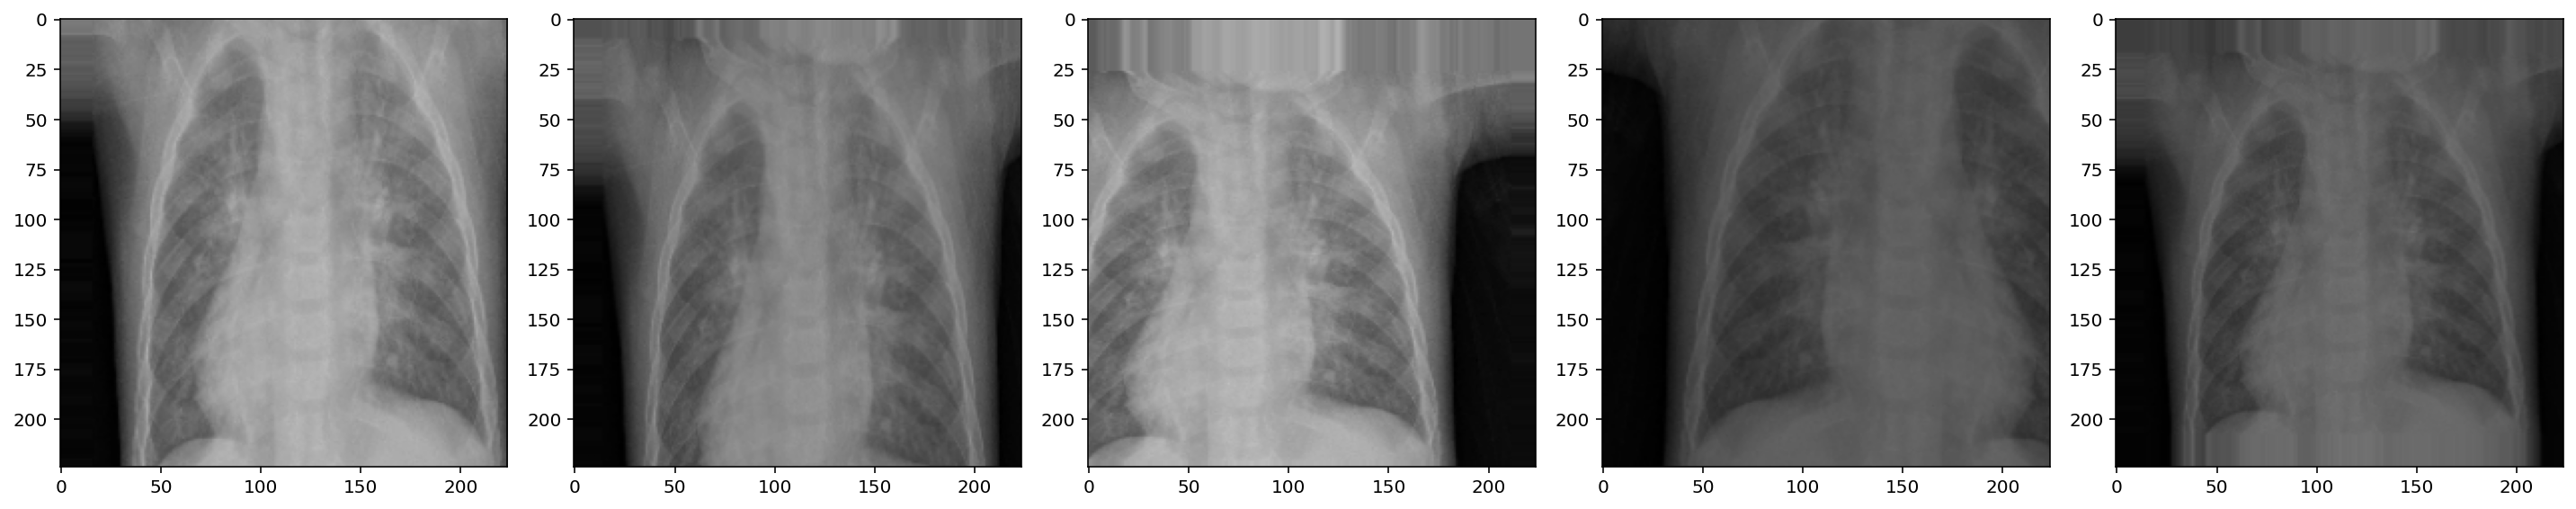

In [44]:
augmented_images = [train_gen[0][0][2] for i in range(5)]
plotImages(augmented_images)

In [45]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

train_lb = to_categorical(train_data.label, dtype = int)
val_lb = to_categorical(val_data.label, dtype=int)

train_data = train_data.reset_index().drop(labels='index', axis=1)
y_train = pd.DataFrame(train_lb).add_prefix('label_')

val_data = val_data.reset_index().drop(labels='index', axis=1)
y_val = pd.DataFrame(val_lb).add_prefix('label_')

train_data = pd.concat([train_data, y_train], axis=1)
val_data = pd.concat([val_data, y_val], axis=1)

print("Training set has {} samples".format(train_data.shape[0]))
print("Validation set has {} samples".format(val_data.shape[0]))

Training set has 5216 samples
Validation set has 16 samples


In [50]:
BATCH_SIZE = 32
IMG_SHAPE  = 224
EPOCHS = 20

def gen():
    train_image_gen = ImageDataGenerator(rescale=1./255,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         brightness_range=[0.2,1.0],
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         fill_mode='nearest')

    train_gen = train_image_gen.flow_from_dataframe(train_data,
                                              x_col='image_path',
                                              y_col=[f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))


    val_image_gen = ImageDataGenerator(rescale=1./255)
    val_gen = val_image_gen.flow_from_dataframe(val_data,
                                              x_col='image_path',
                                              y_col= [f'label_{x}' for x in np.arange(2)],
                                              class_mode='raw',
                                              batch_size=BATCH_SIZE,
                                              target_size=(IMG_SHAPE,IMG_SHAPE))
    return train_gen, val_gen

In [51]:
def plot(history):

    training_accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']

    training_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    epochs_range=range(len(training_accuracy))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, training_loss, label='Training Loss')
    plt.plot(epochs_range, validation_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


In [52]:
from PIL import Image
def predict(image_path, model):
    im = cv2.imread(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis = 0)
    
    ps = model.predict(processed_test_image)
    return ps
    
def process_image(image):
    image = tf.cast(image , tf.float32)
    image = tf.image.resize(image , (224 , 224))
    image = image/255
    image = image.numpy()
    return image

In [53]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 16)      1040      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      4

In [54]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', np.unique(train_data['label']), train_data.label)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

In [55]:
train_gen, val_gen = gen()

optm = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optm, 
                  metrics=['accuracy'])

EarlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=.0001,
                              patience=3,
                              verbose=1,
                              mode='auto',
                              baseline=None,
                              restore_best_weights=True)

model_save = ModelCheckpoint('./baseline_model.h5',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)


base_history = model.fit(train_gen,
                             steps_per_epoch = train_gen.samples // BATCH_SIZE,
                             epochs = 20,
                             validation_data = val_gen,
                             callbacks=[EarlyStopping,model_save],
                             class_weight = class_weights)

Found 5216 validated image filenames.
Found 16 validated image filenames.
Epoch 1/20
163/163 [==============================] - ETA: 0s - loss: 1.2027 - accuracy: 0.5148
Epoch 00001: val_loss improved from inf to 0.71911, saving model to .\baseline_model.h5
163/163 [==============================] - 425s 3s/step - loss: 1.2027 - accuracy: 0.5148 - val_loss: 0.7191 - val_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - ETA: 0s - loss: 1.0110 - accuracy: 0.5393
Epoch 00002: val_loss did not improve from 0.71911
163/163 [==============================] - 460s 3s/step - loss: 1.0110 - accuracy: 0.5393 - val_loss: 1.0640 - val_accuracy: 0.5000
Epoch 3/20
163/163 [==============================] - ETA: 0s - loss: 0.8957 - accuracy: 0.5715
Epoch 00003: val_loss did not improve from 0.71911
163/163 [==============================] - 432s 3s/step - loss: 0.8957 - accuracy: 0.5715 - val_loss: 4.0327 - val_accuracy: 0.5000
Epoch 4/20
163/163 [==============================] 

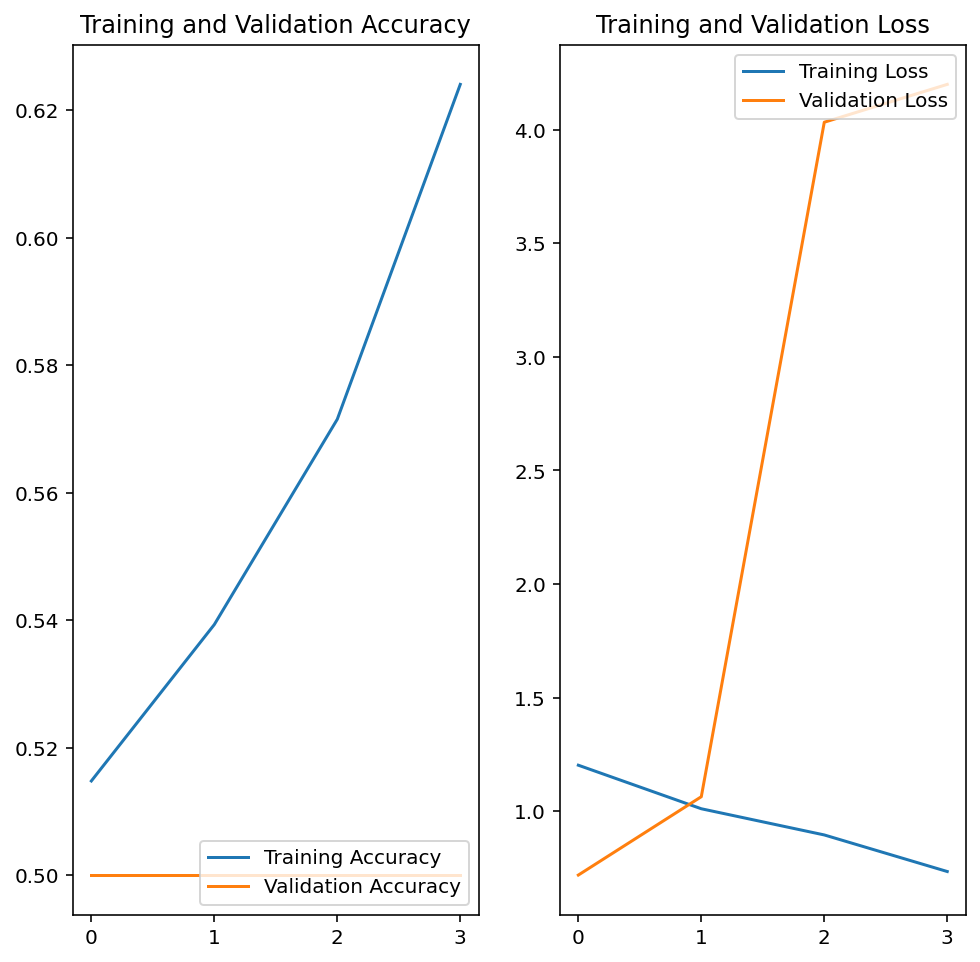

In [56]:
plot(base_history)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



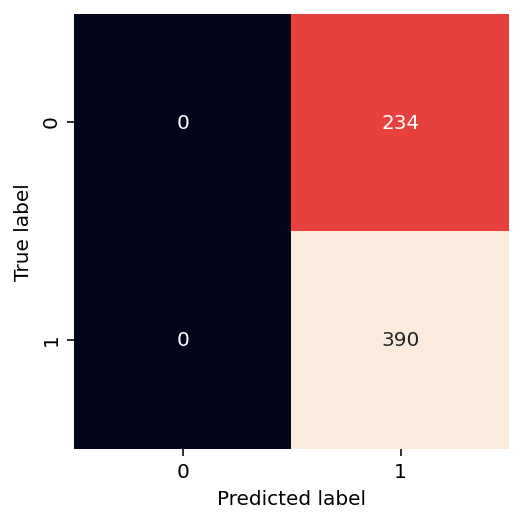

In [57]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


base_pred =[]
for image in test_data.image_path:
    base_pred.append(predict(image , model))
    
final_base_pred  = np.argmax(base_pred , axis=-1)
actual_label = test_data['label']

print(classification_report(actual_label, final_base_pred))
matrix=confusion_matrix(actual_label, final_base_pred)
sns.heatmap(matrix,square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.xlabel('Predicted label')
plt.ylabel('True label');